Assignment-3

By: **Mahsa Malek, Shirin Yamani**


This assignment is composed of 2 tasks that your teams is supposed complete.

Create a function to remove "blank slices" from a 3D dataset, which in this case consist of a 3D brain magnetic resonance image. "Blank slices" are slices that do not have signal in them. The "blank slices" should be removed across all three dimensions of the 3D volume.
Implement our use an existing data augmentation and generation utility for image segmentation applications
The deliverable of this assignment is this jupyter-notebook completed with your solution.

- Create a folder assignment-03. Put the jupyter-notebook with your solution in this repository and send the instructor the link. The repository is the same repository that your team created for assignment 1 and your team final project.

You are being assessed based on:

1. Code execution - 20%

2. Clarity of the code (e.g., easy to follow, has pertinent comments, etc.) - 20%

3. Proper usage of the techniques seen in class - 40%

4. Quality of the results - 20%

More details about the assessment are available in the rubric document in the class GitHub repository.

# **Remove Blank Slices**

For this function, remember that a blank slice is different from a slice that does not have the structire you want to segment.

In [ ]:
import sys
sys.path.append('/content/gdrive/My Drive/Data')
import numpy as np
import nibabel as nib
import matplotlib.pylab as plt
import os
import albumentations as A
from google.colab import drive

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# Checking whether the plane is blank or not!
def is_blank(plane): 
    # checking if there is enough variation in the matrix
    if np.std(plane) < 210:
      return True
    return False

In [ ]:
# to remove the blank slices   
def remove_blank_slices(im, mask):
  # We remove blank slices perpendicular to each dimension
  reconst_mask = [] # non-filtered mask slices
  reconst_im = [] # non-filtered image slices
  for x in range(im.shape[0]):
    plane_mask=mask[x,:,:]
    plane_im=im[x,:,:]
    if not is_blank(plane_im):
      reconst_mask.append(plane_mask) # keep this mask slice (it is useful)
      reconst_im.append(plane_im) # keep this image slice (it is useful)
  im = np.stack(reconst_im, axis=0)
  mask = np.stack(reconst_mask, axis=0)
  
  reconst_mask = []
  reconst_im = []
  for y in range(im.shape[1]):
    plane_mask=mask[:,y,:]
    plane_im=im[:,y,:]
    if not is_blank(plane_im):
      reconst_mask.append(plane_mask) 
      reconst_im.append(plane_im)
  im = np.stack(reconst_im, axis=1)
  mask = np.stack(reconst_mask, axis=1)
            
  reconst_mask = []
  reconst_im = []
  for z in range(im.shape[2]):
    plane_mask=mask[:,:,z]
    plane_im=im[:,:,z]
    if not is_blank(plane_im):
      reconst_mask.append(plane_mask)
      reconst_im.append(plane_im)
  im = np.stack(reconst_im, axis=1)
  mask = np.stack(reconst_mask, axis=1)

  return im, mask

Image and mask shapes before cropping
(171, 256, 256) (171, 256, 256)


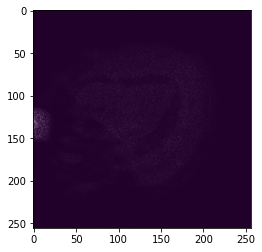

Image and mask shapes after cropping
(156, 209, 192) (156, 209, 192)


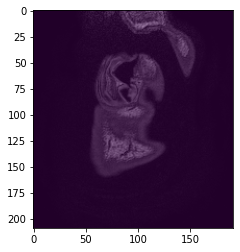

In [ ]:
gdrive_prefix = '/content/gdrive/My Drive/Data'
data_path=os.path.join(gdrive_prefix,"CC0001_philips_15_55_M.nii.gz")
mask_path=os.path.join(gdrive_prefix,"CC0001_philips_15_55_M_staple.nii.gz")


data = nib.load(data_path).get_fdata() 

mask = nib.load(mask_path).get_fdata()

print("Image and mask shapes before cropping")
print(data.shape, mask.shape)


plt.figure()
plt.imshow(data[-1], cmap = "gray")
plt.imshow(mask[-1], alpha = 0.5)
plt.show()

data_cropped, mask_cropped = remove_blank_slices(data ,mask)

print("Image and mask shapes after cropping")
print(data_cropped.shape, mask_cropped.shape)

plt.figure()
plt.imshow(data_cropped[-1], cmap = "gray")
plt.imshow(mask_cropped[-1], alpha = 0.5)
plt.show()

# **Data Augmentation and Generation**

You can use available utils to propose a solution for this portio nof the assignment.

[Imgaug](https://imgaug.readthedocs.io/en/latest/)

[Albumentations](https://albumentations.ai/)

Keras. There is a nice tutorial [here](https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly).
You can also extend the Data Generation utils we created in class to include data augmentation operations [here](https://notebooks.githubusercontent.com/view/data_generator.py)

Remember, the essential steps are:

1. Load a batch of images (randomly and from random volumes)
 
2. Apply a predetrmined set of random data augmentation transformations

3. Crop the images and mask to a specific patch size and return a batch of samples.





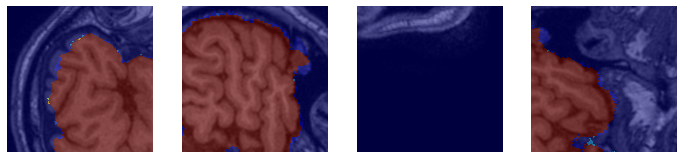

In [ ]:
from data_generator import DataGeneratorUnet
import glob

imgs_list_train = glob.glob(os.path.join(gdrive_prefix, 'Sample', 'Images', '*.npy'))
masks_list_train = glob.glob(os.path.join(gdrive_prefix, 'Sample', 'Masks', '*.npy'))

# defining the transformation
transform = A.Compose([
    A.Resize(int(512 * 1.42), int(512 * 1.42)),
    A.Rotate(),
    A.CenterCrop(512, 512),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5)
])

batch_size = 4

gen_train = DataGeneratorUnet(imgs_list_train,masks_list_train,batch_size = batch_size)
X,Y = gen_train.__getitem__(0)
plt.figure(figsize = (12,18))
for ii in range(batch_size):
    im = X[ii,:,:,0]
    mask = Y[ii,:,:,0]
    
    # based on https://albumentations.ai/docs/getting_started/mask_augmentation/
    # this will apply the same transformation to both the image and the mask

    after_transformation = transform(image=im, mask=mask)
    im = after_transformation['image']
    mask = after_transformation['mask']
    plt.subplot(1, 4, ii+1)
    plt.imshow(im, cmap = "gray")
    plt.axis("off")
    plt.imshow(mask, cmap='jet', alpha=0.5, interpolation='none')
    plt.axis("off")
plt.show()